# Importación de librerías

In [7]:
import pandas as pd
import numpy as np
import time 

import os
import librosa
import librosa.display

import matplotlib.pyplot as plt
import seaborn as sns

import mlflow


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Lectura del dataset

In [9]:
urbansound8k_path = "../../data/raw/UrbanSound8K/"

# Primer dataset - Carpeta con los audios
urbansound8k_audio_path = "audio/"

# Segundo dataset - Archivo CSV con metadatos sobre los audios
urbansound8k_metadata_path_file = "metadata/UrbanSound8K.csv" 

# Dataset input
dataset_input_path = "../../data/processed/dataset_mfcc_20.csv"


In [10]:
# Lectura
dataset_urbansound8k_df = pd.read_csv(dataset_input_path, sep=";")
dataset_urbansound8k_df.head(3)

,fold,classID,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,...,delta2_mfcc_var_1,delta2_mfcc_var_2,delta2_mfcc_var_3,delta2_mfcc_var_4,delta2_mfcc_var_5,delta2_mfcc_var_6,delta2_mfcc_var_7,delta2_mfcc_var_8,delta2_mfcc_var_9,delta2_mfcc_var_10
0,5,3,-275.91843,119.49280,-98.21178,-66.515140,-42.606050,0.505066,-28.330938,-5.746867,...,112.505020,213.598100,39.538475,116.963340,28.015196,153.756260,35.081203,40.550793,19.388300,49.317924
1,5,2,-500.90840,185.10641,-86.53282,49.858850,9.230822,22.548956,-3.567175,12.220052,...,45.168175,41.733723,32.465210,30.765085,34.802017,35.170403,32.595600,35.089226,29.046677,31.543688
2,5,2,-531.19530,186.93994,-70.34916,40.429245,9.121047,18.398588,6.283282,15.504061,...,37.555386,37.222927,33.088345,33.774395,34.858345,33.916622,30.953386,31.146223,27.312347,28.527649


In [11]:
print(f"Cantidad de columnas: {dataset_urbansound8k_df.shape[1]}")
print(f"Cantidad de filas: {dataset_urbansound8k_df.shape[0]}")

print("Columnas del dataset:")
contador = 0
for name in dataset_urbansound8k_df.columns:
    contador +=1
    if contador%5==0:
        print("")        
    print(f"'{name}'", end=", ")

Cantidad de columnas: 112
Cantidad de filas: 8732
Columnas del dataset:
'fold', 'classID', 'mfcc_mean_1', 'mfcc_mean_2', 
'mfcc_mean_3', 'mfcc_mean_4', 'mfcc_mean_5', 'mfcc_mean_6', 'mfcc_mean_7', 
'mfcc_mean_8', 'mfcc_mean_9', 'mfcc_mean_10', 'mfcc_median_1', 'mfcc_median_2', 
'mfcc_median_3', 'mfcc_median_4', 'mfcc_median_5', 'mfcc_median_6', 'mfcc_median_7', 
'mfcc_median_8', 'mfcc_median_9', 'mfcc_median_10', 'mfcc_min_1', 'mfcc_min_2', 
'mfcc_min_3', 'mfcc_min_4', 'mfcc_min_5', 'mfcc_min_6', 'mfcc_min_7', 
'mfcc_min_8', 'mfcc_min_9', 'mfcc_min_10', 'mfcc_max_1', 'mfcc_max_2', 
'mfcc_max_3', 'mfcc_max_4', 'mfcc_max_5', 'mfcc_max_6', 'mfcc_max_7', 
'mfcc_max_8', 'mfcc_max_9', 'mfcc_max_10', 'mfcc_var_1', 'mfcc_var_2', 
'mfcc_var_3', 'mfcc_var_4', 'mfcc_var_5', 'mfcc_var_6', 'mfcc_var_7', 
'mfcc_var_8', 'mfcc_var_9', 'mfcc_var_10', 'mfcc_skew_1', 'mfcc_skew_2', 
'mfcc_skew_3', 'mfcc_skew_4', 'mfcc_skew_5', 'mfcc_skew_6', 'mfcc_skew_7', 
'mfcc_skew_8', 'mfcc_skew_9', 'mfcc_skew_10', '

# Generación datos de entrenamiento y prueba

In [12]:
# Separar las características y la variable objetivo
# ['tasa_cruce_cero', 'entropia_espectograma', 'avg_centroide_espectral'
columnas_caracteristicas_mfcc = [col for col in dataset_urbansound8k_df.columns if 'mfcc' in col]
columna_predecir = 'classID'
columna_fold = 'fold'

# Separar las características y etiquetas
X_caracteristicas = dataset_urbansound8k_df[columnas_caracteristicas_mfcc]  # 'classID' es la etiqueta y 'fold' el número de fold
y = dataset_urbansound8k_df[columna_predecir]
folds = dataset_urbansound8k_df['fold']

# Modelos de Clasificacion

In [13]:
# Iniciar el experimento en MLflow
mlflow.set_experiment("RSCV MFCC20 ")

2024/10/26 18:47:15 INFO mlflow.tracking.fluent: Experiment with name 'RSCV MFCC10 ' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///c:/Users/colbe/Documents/VIU/TFM/tfm-clasificador-fuentes-sonoras-ciudad/notebooks/modelado/mlruns/869989259800020411', creation_time=1729986435799, experiment_id='869989259800020411', last_update_time=1729986435799, lifecycle_stage='active', name='RSCV MFCC10 ', tags={}>

## KNeighborsClassifier

Mejores Parámetros: {'weights': 'uniform', 'n_neighbors': 5, 'metric': 'manhattan'}
Mejor Score: 0.5682527025493915
Fold 1 Accuracy: 0.5086
Tiempo de entrenamiento (segundos): 14.2903


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Mejores Parámetros: {'weights': 'uniform', 'n_neighbors': 5, 'metric': 'manhattan'}
Mejor Score: 0.5673115169634733
Fold 2 Accuracy: 0.5304
Tiempo de entrenamiento (segundos): 9.4830


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Mejores Parámetros: {'weights': 'uniform', 'n_neighbors': 10, 'metric': 'manhattan'}
Mejor Score: 0.5781934731934731
Fold 3 Accuracy: 0.4886
Tiempo de entrenamiento (segundos): 10.0709


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Mejores Parámetros: {'weights': 'uniform', 'n_neighbors': 10, 'metric': 'manhattan'}
Mejor Score: 0.5691046094857048
Fold 4 Accuracy: 0.5838
Tiempo de entrenamiento (segundos): 9.9479


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Mejores Parámetros: {'weights': 'uniform', 'n_neighbors': 5, 'metric': 'manhattan'}
Mejor Score: 0.5506530397287779
Fold 5 Accuracy: 0.6218
Tiempo de entrenamiento (segundos): 10.0116


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Mejores Parámetros: {'weights': 'distance', 'n_neighbors': 27, 'metric': 'manhattan'}
Mejor Score: 0.5549221462977483
Fold 6 Accuracy: 0.5164
Tiempo de entrenamiento (segundos): 10.7439


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Mejores Parámetros: {'weights': 'uniform', 'n_neighbors': 5, 'metric': 'manhattan'}
Mejor Score: 0.5700494136144133
Fold 7 Accuracy: 0.5024
Tiempo de entrenamiento (segundos): 11.3236


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Mejores Parámetros: {'weights': 'uniform', 'n_neighbors': 10, 'metric': 'manhattan'}
Mejor Score: 0.5679985542690461
Fold 8 Accuracy: 0.5261
Tiempo de entrenamiento (segundos): 11.1901


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Mejores Parámetros: {'weights': 'uniform', 'n_neighbors': 5, 'metric': 'manhattan'}
Mejor Score: 0.5473569449233165
Fold 9 Accuracy: 0.6225
Tiempo de entrenamiento (segundos): 11.8766


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Mejores Parámetros: {'weights': 'uniform', 'n_neighbors': 5, 'metric': 'manhattan'}
Mejor Score: 0.5559084564662848
Fold 10 Accuracy: 0.5854
Tiempo de entrenamiento (segundos): 10.8147


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(



Accuracy promedio: 0.5486
Desviación estándar: 0.0476


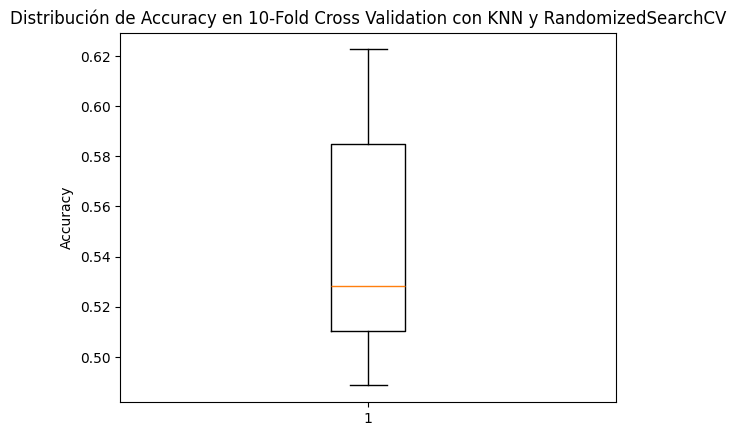

In [14]:
# Definir el modelo KNN
knn = KNeighborsClassifier()

# Definir la rejilla de parámetros para RandomizedSearchCV
param_distributions = {
    'n_neighbors': np.arange(1, 31),  # Número de vecinos a considerar
    'weights': ['uniform', 'distance'],  # Función de peso a usar
    'metric': ['euclidean', 'manhattan', 'minkowski']  # Métrica de distancia
}

# Inicializar lista para almacenar accuracies y tiempos
fold_accuracies = []
fold_training_times = []

# Realizar la validación cruzada respetando los folds predefinidos
for fold in range(1, 11):  # Hay 10 folds en UrbanSound8K

    # Dividir el dataset en entrenamiento y prueba
    train_index = folds != fold
    test_index = folds == fold
    
    X_train, X_test = X_caracteristicas[train_index], X_caracteristicas[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Configurar RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=knn, 
        param_distributions=param_distributions, 
        n_iter=10,  # Número de combinaciones aleatorias a probar
        cv=10,  # Validación cruzada interna con 10 pliegues
        scoring='accuracy',  # Métrica para optimizar
        n_jobs=-1,  # Usar todos los núcleos disponibles
        random_state=42
    )

    # Medir el tiempo de entrenamiento
    start_time = time.time()  # Inicio del tiempo

    # Entrenar el modelo con la búsqueda de hiperparámetros
    random_search.fit(X_train, y_train)

    # Tiempo de finalización
    end_time = time.time()

    # Calcular el tiempo de entrenamiento
    training_time = end_time - start_time
    fold_training_times.append(training_time)

    # Obtener el mejor modelo
    best_knn = random_search.best_estimator_

    # Obtener los mejores parámetros y el mejor score
    best_params = random_search.best_params_
    best_score = random_search.best_score_    
    
    # Predecir y evaluar
    y_pred = best_knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    fold_accuracies.append(accuracy)

    
    print(f"Mejores Parámetros: {best_params}")
    print(f"Mejor Score: {best_score}")        
    print(f"Fold {fold} Accuracy: {accuracy:.4f}")
    print(f"Tiempo de entrenamiento (segundos): {training_time:.4f}")

    with mlflow.start_run(run_name=f"KNN RSCV Fold_{fold}") as run:
        # Registrar los parámetros y métricas en MLflow
        mlflow.log_params(best_params)

        # Registrar la métrica de accuracy de este fold
        mlflow.log_metric(f"accuracy_score", accuracy)

        # Registrar el tiempo de entrenamiento
        mlflow.log_metric(f"training_time_seconds", training_time)

        # Guardar el modelo en MLflow con un ejemplo de entrada
        input_example = X_test[:1]  # Ejemplo de entrada, una sola muestra de prueba
        mlflow.sklearn.log_model(best_knn, f"knn_model_fold_{fold}", input_example=input_example)

        # Se finaliza el registro
        mlflow.end_run()


# Mostrar el promedio y desviación estándar
mean_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)

print(f"\nAccuracy promedio: {mean_accuracy:.4f}")
print(f"Desviación estándar: {std_accuracy:.4f}")


# Opcional: Visualizar los resultados con un boxplot
plt.boxplot(fold_accuracies)
plt.title('Distribución de Accuracy en 10-Fold Cross Validation con KNN y RandomizedSearchCV')
plt.ylabel('Accuracy')
plt.show()


## Random Forest

Mejores Parámetros: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 50, 'bootstrap': False}
Mejor Score: 0.685072191014814
Fold 8 Accuracy: 0.6725
Tiempo de entrenamiento (segundos): 478.9476


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Mejores Parámetros: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20, 'bootstrap': False}
Mejor Score: 0.6808647473470482
Fold 9 Accuracy: 0.6985
Tiempo de entrenamiento (segundos): 421.9503


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Mejores Parámetros: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 50, 'bootstrap': False}
Mejor Score: 0.6899122427042724
Fold 10 Accuracy: 0.7431
Tiempo de entrenamiento (segundos): 433.0376


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(



Accuracy promedio: 0.7047
Desviación estándar: 0.0292
Tiempo de entrenamiento promedio (segundos): 444.6452


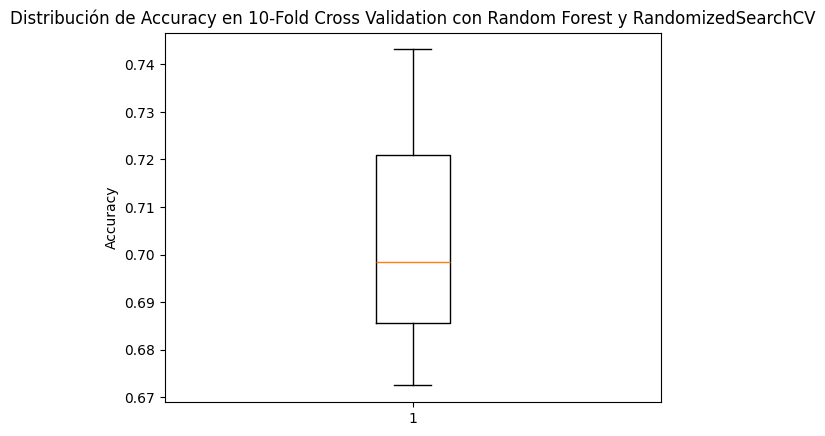

In [17]:
# Definir el modelo Random Forest
rf = RandomForestClassifier(random_state=42)

# Definir la rejilla de parámetros para RandomizedSearchCV
param_distributions = {
    'n_estimators': [10, 50, 100, 200, 500],  # Número de árboles en el bosque
    'max_depth': [None, 10, 20, 30, 40, 50],  # Máxima profundidad de cada árbol
    'min_samples_split': [2, 5, 10],  # Mínimo número de muestras requeridas para dividir un nodo
    'min_samples_leaf': [1, 2, 4],  # Mínimo número de muestras requeridas en una hoja
    'max_features': ['sqrt', 'log2'],  # Número de características a considerar al buscar la mejor división
    'bootstrap': [True, False]  # Método para seleccionar muestras para construir cada árbol
}

# Inicializar lista para almacenar accuracies y tiempos
fold_accuracies = []
fold_training_times = []  # Lista para almacenar los tiempos de entrenamiento

# Realizar la validación cruzada respetando los folds predefinidos
for fold in range(1, 11):  # Hay 10 folds en UrbanSound8K
    # Dividir el dataset en entrenamiento y prueba
    train_index = folds != fold
    test_index = folds == fold
    
    X_train, X_test = X_caracteristicas[train_index], X_caracteristicas[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Configurar RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=rf, 
        param_distributions=param_distributions, 
        n_iter=10,  # Número de combinaciones aleatorias a probar
        cv=10,  # Validación cruzada interna con 10 pliegues
        scoring='accuracy',  # Métrica para optimizar
        n_jobs=-1,  # Usar todos los núcleos disponibles
        random_state=42
    )

    # Medir el tiempo de entrenamiento
    start_time = time.time()  # Inicio del tiempo

    # Entrenar el modelo con la búsqueda de hiperparámetros
    random_search.fit(X_train, y_train)

    # Tiempo de finalización
    end_time = time.time()

    # Calcular el tiempo de entrenamiento
    training_time = end_time - start_time
    fold_training_times.append(training_time)

    # Obtener el mejor modelo
    best_rf = random_search.best_estimator_

    # Obtener los mejores parámetros y el mejor score
    best_params = random_search.best_params_
    best_score = random_search.best_score_
    
    # Predecir y evaluar
    y_pred = best_rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    fold_accuracies.append(accuracy)

    print(f"Mejores Parámetros: {best_params}")
    print(f"Mejor Score: {best_score}")
    print(f"Fold {fold} Accuracy: {accuracy:.4f}")
    print(f"Tiempo de entrenamiento (segundos): {training_time:.4f}")

    with mlflow.start_run(run_name=f"RandomForest RSCV Fold_{fold}") as run:
        # Registrar los parámetros y métricas en MLflow
        mlflow.log_params(best_params)

        # Registrar la métrica de accuracy de este fold
        mlflow.log_metric(f"accuracy_score", accuracy)

        # Registrar el tiempo de entrenamiento
        mlflow.log_metric(f"training_time_seconds", training_time)

        # Guardar el modelo en MLflow con un ejemplo de entrada
        input_example = X_test[:1]  # Ejemplo de entrada, una sola muestra de prueba
        mlflow.sklearn.log_model(best_rf, f"rf_model_fold_{fold}", input_example=input_example)

        # Se finaliza el registro
        mlflow.end_run()


# Mostrar el promedio y desviación estándar
mean_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)
mean_training_time = np.mean(fold_training_times)

print(f"\nAccuracy promedio: {mean_accuracy:.4f}")
print(f"Desviación estándar: {std_accuracy:.4f}")
print(f"Tiempo de entrenamiento promedio (segundos): {mean_training_time:.4f}")

# Opcional: Visualizar los resultados con un boxplot
plt.boxplot(fold_accuracies)
plt.title('Distribución de Accuracy en 10-Fold Cross Validation con Random Forest y RandomizedSearchCV')
plt.ylabel('Accuracy')
plt.show()

## SVM

In [18]:
# Definir el modelo SVM
svm = SVC()

# Definir la rejilla de parámetros para RandomizedSearchCV
param_distributions = {
    'C': [0.001, 0.0001],  # Parámetro de regularización
    'kernel': ['linear', 'rbf'],  # Tipo de kernel
    'gamma': ['scale', 'auto'],  # Coeficiente del kernel 'rbf', 'poly' o 'sigmoid' 
}

# Inicializar lista para almacenar accuracies y tiempos
fold_accuracies = []
fold_training_times = []  # Lista para almacenar los tiempos de entrenamiento

# Realizar la validación cruzada respetando los folds predefinidos
for fold in range(1, 11):  # Hay 10 folds en UrbanSound8K
    # Dividir el dataset en entrenamiento y prueba
    train_index = folds != fold
    test_index = folds == fold
    
    X_train, X_test = X_caracteristicas[train_index], X_caracteristicas[test_index]
    y_train, y_test = y[train_index], y[test_index]

    print("iniciando")

    # Configurar RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=svm, 
        param_distributions=param_distributions, 
        n_iter=5,  # Número de combinaciones aleatorias a probar
        cv=10,  # Validación cruzada interna 
        scoring='accuracy',  # Métrica para optimizar
        n_jobs=-1,  # Usar todos los núcleos disponibles
        random_state=42
    )

    # Medir el tiempo de entrenamiento
    start_time = time.time()  # Inicio del tiempo

    # Entrenar el modelo con la búsqueda de hiperparámetros
    random_search.fit(X_train, y_train)

    # Tiempo de finalización
    end_time = time.time()

    # Calcular el tiempo de entrenamiento
    training_time = end_time - start_time
    fold_training_times.append(training_time)

    # Obtener el mejor modelo
    best_svm = random_search.best_estimator_

    # Obtener los mejores parámetros y el mejor score
    best_params = random_search.best_params_
    best_score = random_search.best_score_
    
    # Predecir y evaluar
    y_pred = best_svm.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    fold_accuracies.append(accuracy)

    print(f"Mejores Parámetros: {best_params}")
    print(f"Mejor Score: {best_score}")
    print(f"Fold {fold} Accuracy: {accuracy:.4f}")
    print(f"Tiempo de entrenamiento (segundos): {training_time:.4f}")

    with mlflow.start_run(run_name=f"SVM RSCV MFCC20 Fold_{fold}") as run:
        # Registrar los parámetros y métricas en MLflow
        mlflow.log_params(best_params)

        # Registrar la métrica de accuracy de este fold
        mlflow.log_metric(f"accuracy_score", accuracy)

        # Registrar el tiempo de entrenamiento
        mlflow.log_metric(f"training_time_seconds", training_time)

        # Guardar el modelo en MLflow con un ejemplo de entrada
        input_example = X_test[:1]  # Ejemplo de entrada, una sola muestra de prueba
        mlflow.sklearn.log_model(best_svm, f"svm_rscv_mfcc20_fold_{fold}", input_example=input_example)

        # Se finaliza el registro
        mlflow.end_run()


# Mostrar el promedio y desviación estándar
mean_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)
mean_training_time = np.mean(fold_training_times)

print(f"\nAccuracy promedio: {mean_accuracy:.4f}")
print(f"Desviación estándar: {std_accuracy:.4f}")
print(f"Tiempo de entrenamiento promedio (segundos): {mean_training_time:.4f}")

# Opcional: Visualizar los resultados con un boxplot
plt.boxplot(fold_accuracies)
plt.title('Distribución de Accuracy en 10-Fold Cross Validation con SVM y RandomizedSearchCV')
plt.ylabel('Accuracy')
plt.show()


iniciando
Mejores Parámetros: {'kernel': 'linear', 'gamma': 'scale', 'C': 0.01}
Mejor Score: 0.6496875253237386
Fold 1 Accuracy: 0.6094
Tiempo de entrenamiento (segundos): 2651.8384


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


iniciando
